# Visual Odometry pipeline
A naive visual odometry implementation with OpenCV (for now), NumPy & Python

In [1]:
# Fetch data
!bash ../fetch_data.sh

### Run with KITTI
Make sure to download the KITTI odometry dataset and set KITTI=True

### Run with ad-hoc video
Set KITTI variable to False and input variable to the video

In [2]:
import cv2
import time
import numpy as np
from matplotlib import pyplot as plt
from os import listdir
from os.path import isfile, join
# Handrolled
from utils import display_mat, draw_points
from ransac import ransac
from features import extract_features, compute_orb_descriptors, bruteforce_match
from geometry import triangulate, fundamentalToEssential, \
    extract_pose, normalize, FundamentalMatrixModel, integrate_pose, calculate_projection, create_normalization_matrix

## Parameters
- KITTI: Defines if the KITTI dataset should be used (requires download from kaggle or the KITTI website)
- input: If KITTI isn't used, this is the file to load for doing VO.
- max_corners: Maximum keypoints returned from goodFeatureToTrack.
- kernel_size: Size of the kernel to search for features with.
- quality: Corner detector "quality".
- ransac_minsamples: The number of samples used by RANSAC
- ransac_max_trial: maximum iteraions of the RANSAC search.
- ransac_residual_threshold: The residual threshold for ransac

In [3]:
# Script parameters
KITTI = True
KITTI_DATA_DIRECTORY = '/Users/haydenpennington/dev/data/kitti/'
input = '../videos/test_countryroad.mp4'
# input = 0
im_size = (640, 480)

# ORB Detector parameters
max_corners = 1500
kernel_size = 6
quality = 0.001
keypoint_size = 18

# Ransac parameters
ransac_minsamples = 8
ransac_max_trials = 150
ransac_residual_threshold = 0.001

# Pose extratction translation scaling
tscale = 1.0

# Point cloud clustering
n_points = 2
dbscan_eps = tscale * 0.5

In [4]:
%matplotlib widget

seq = None
mono_folder = None
data_folder = None
train_image_names = None
train_labels = None

if KITTI == True:
    seq = '00'  
    mono_folder = 'image_2'
    data_root = KITTI_DATA_DIRECTORY
    data_folder = data_root + 'sequences/' + seq + '/' + mono_folder + '/'
    train_image_names = sorted([f for f in listdir(data_folder) if isfile(join(data_folder, f))])
    
    with open(data_root + 'poses/' + seq + '.txt', 'r') as f:
        train_labels = [x.split() for x in f.readlines()]
        train_labels = np.array([[float(x) for x in y] for y in train_labels])
        train_labels = train_labels.reshape(-1, 3, 4)


cap = None
if KITTI == False:
    cap = cv2.VideoCapture(input)

In [5]:
def get_image(i, im_size):
    if KITTI == True:
        im = cv2.imread(data_folder + train_image_names[i])
        im_bw = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
        im_resized = cv2.resize(im_bw, im_size)
        return True, im, im_resized
    else:
        ret, im = cap.read()
        im_bw = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
        im_resized = cv2.resize(im_bw, im_size)
        return ret, im, im_resized

In [6]:
def match_frames(T, H, W, kps1, kps2, descriptors1, descriptors2):    
    matches = bruteforce_match(descriptors1, descriptors2)

    pairs = []
    norm_pairs = []
    indices = []

    for m,n in matches:
        # Check Lowe's ratio
        if m.distance < 0.75 * n.distance:
            pt1 = np.asarray(kps1[m.queryIdx].pt)
            pt2 = np.asarray(kps2[m.trainIdx].pt)
            pairs.append((pt1, pt2))

    pairs = np.asarray(pairs)
    norm_pairs = np.zeros_like(pairs)
    norm_x = normalize(T, pairs[:, 0])
    norm_y = normalize(T, pairs[:, 1])
    norm_pairs[:, 0] = norm_x
    norm_pairs[:, 1] = norm_y

    # Filter with ransac
    if norm_pairs[:, 0].shape[0] >= ransac_minsamples and norm_pairs[:, 1].shape[0] >= ransac_minsamples:
        F, inliers = ransac(
            FundamentalMatrixModel(),
            norm_pairs,
            min_samples=ransac_minsamples,
            residual_threshold=ransac_residual_threshold,
            max_trials=ransac_max_trials
        )

        return norm_pairs[inliers], pairs[inliers], F

    else:
        return None

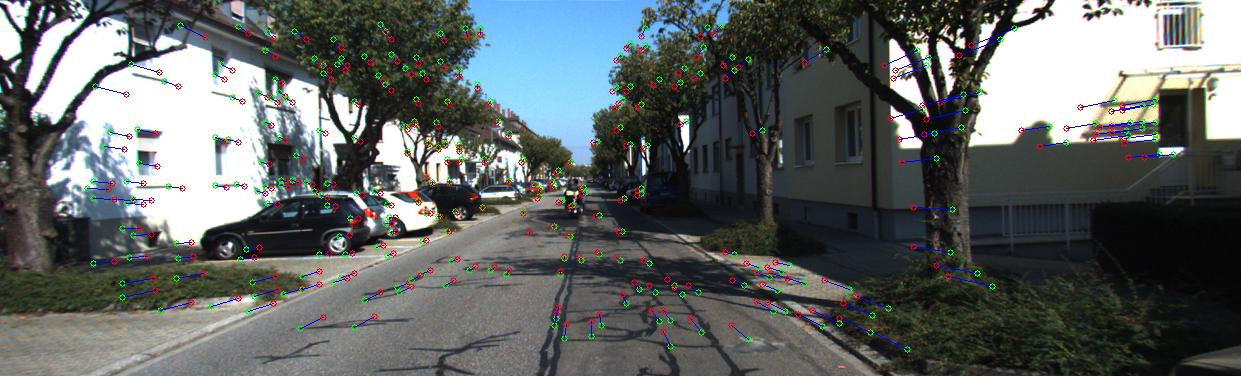

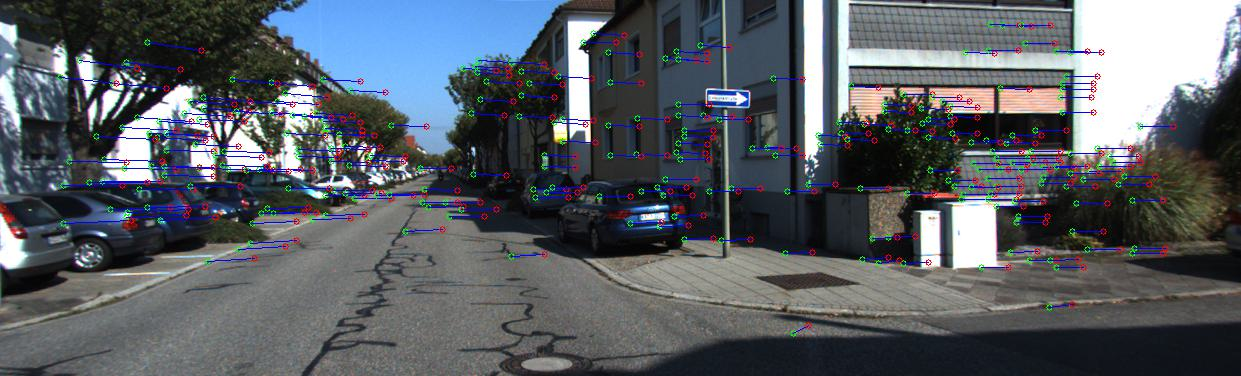

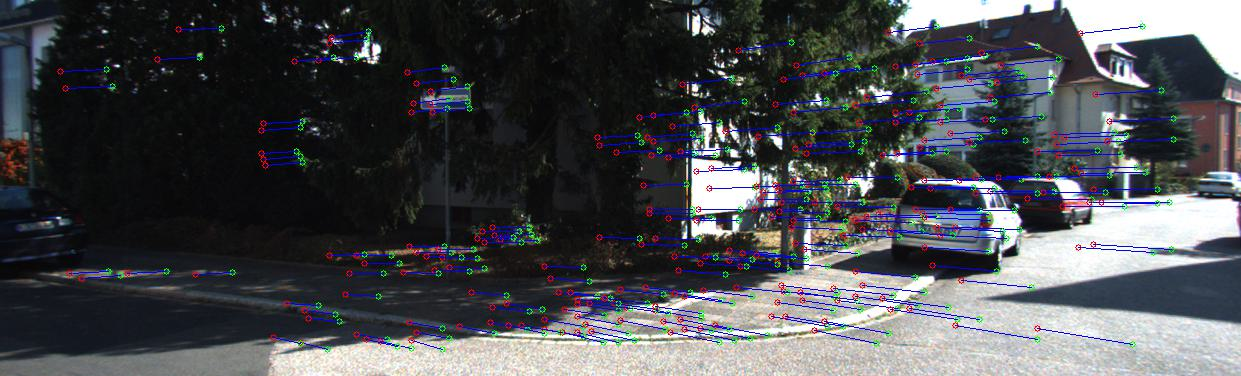

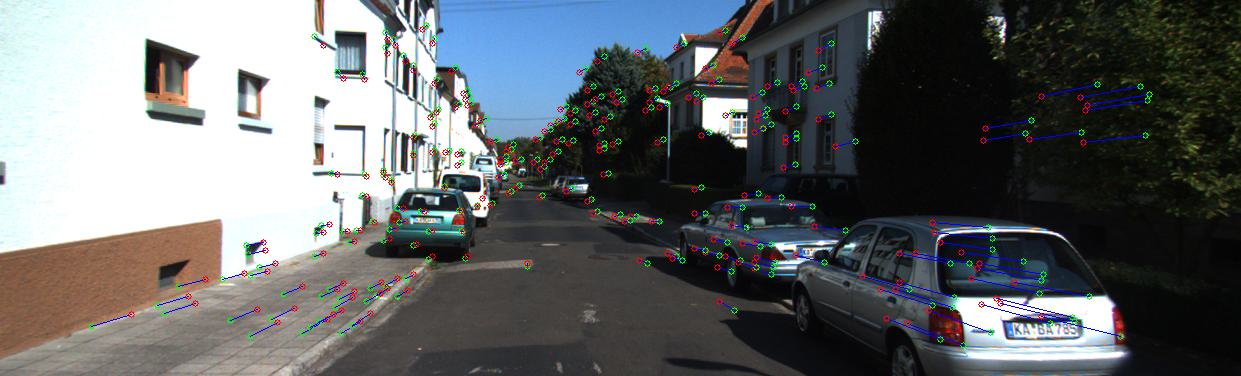

In [7]:
last = None
last_kps = None
last_descriptors = None
point_cloud = None
last_proj = None

pose_abs = np.eye(4)
t_abs_all = []
t_abs_gt = []

i = 0

while (KITTI == True and i < len(train_image_names)) or (cap is not None and cap.isOpened()):
    t0 = time.time()
    ret, im_original, im = get_image(i, im_size)
    label = train_labels[i]
    
    if ret:
        
        multiplier_x = im_original.shape[1] / im.shape[1]
        multiplier_y = im_original.shape[0] / im.shape[0]
        
        # Create the transformation matrix for normalization
        H, W = im.shape
        T = create_normalization_matrix(H, W)

        if last is not None:
            im1 = im
            im2 = last

            key_points = extract_features(im1, max_corners, quality, kernel_size, keypoint_size)
            kps, descriptors = compute_orb_descriptors(im1, key_points)

            H, W = im1.shape
            result = match_frames(T, H, W, kps, last_kps, descriptors, last_descriptors)

            if result is not None:
                norm_pairs, feature_pairs, F = result

                E = fundamentalToEssential(F)
                R, t = extract_pose(E, norm_pairs[0, 0], norm_pairs[0, 1])
                
                pose_abs = integrate_pose(pose_abs, R, t)
                
                t_abs = pose_abs[:3, 3] / pose_abs[3, 3]
                t_abs_all.append(t_abs)
                
                if KITTI == True:
                    t_abs_gt.append(label[:3, 3])
                
                Rt = np.eye(4)
                proj1 = Rt

                if last_proj is not None:
                    proj1 = calculate_projection(R, t, last_proj)
                    kps1 = norm_pairs[:, 0]
                    kps2 = norm_pairs[:, 1]
                    
                    # Triangulate 4d points
                    points4d = triangulate(proj1[:3, :4], last_proj[:3, :4], kps1, kps2, R, t)
                    # 4d homogeneous -> 3d
                    points3d = (points4d / points4d[:, 3:])[:, :3]

                    if point_cloud is None:
                        point_cloud = points3d.reshape(-1, 3)
                    else:
                        point_cloud = np.concatenate([point_cloud, points3d.reshape(-1, 3)]).reshape(-1, 3)
                
                last_proj = proj1

                draw_points(im_original, feature_pairs, multiplier_x, multiplier_y)
        
        last = im

        if last_kps is None:
            keypoints = extract_features(im, max_corners, quality, kernel_size, keypoint_size)
            last_kps, last_descriptors = compute_orb_descriptors(im, keypoints)
        else:
            last_kps, last_descriptors = kps, descriptors

        cv2.imshow('im', im_original)
        key = cv2.waitKey(1)
        if key & 0xFF == ord('q'):
            break

        if (i > 99 and i % 100 == 0) or (i > 0 and i < 11 and i % 10 == 0):
            display_mat(cv2.cvtColor(im_original, cv2.COLOR_BGR2RGB))

        t1 = time.time()
        t_delta = (t1 - t0)
        # print (1 / t_delta)
        i += 1

    else:
        break

cv2.destroyAllWindows()
cv2.waitKey(4)
if KITTI == False:
    cap.release()

### Save the point cloud for viewing in open3d

In [8]:
t_abs_all = np.array(t_abs_all).reshape(-1, 3)

if point_cloud is not None:
    
    import open3d as o3d

    pcd = o3d.geometry.PointCloud()
    pcd.transform([
        [-1, 0,  0, 0],
        [ 0, 1,  0, 0],
        [ 0, 0, 1, 0],
        [ 0, 0,  0, 1]
    ])
    pcd.points = o3d.utility.Vector3dVector(point_cloud)
    ret = np.array(pcd.cluster_dbscan(eps=dbscan_eps, min_points=n_points))
    all_points = np.concatenate([point_cloud[ret > -1], t_abs_all])
    
    pcd.points = o3d.utility.Vector3dVector(all_points)
    
    colors = np.full(all_points.shape, fill_value=(255, 0, 0))
    colors[point_cloud[ret>-1].shape[0]:point_cloud[ret>-1].shape[0]+t_abs_all.shape[0]] = [0, 255, 0]

    pcd.colors = o3d.utility.Vector3dVector(colors)


    o3d.io.write_point_cloud("../pointcloud_clustered.pcd", pcd)

## Plot the 3d trajectory of the camera
### Red vs Green
Red is the ground truth pose and green is the predicted pose of the camera.

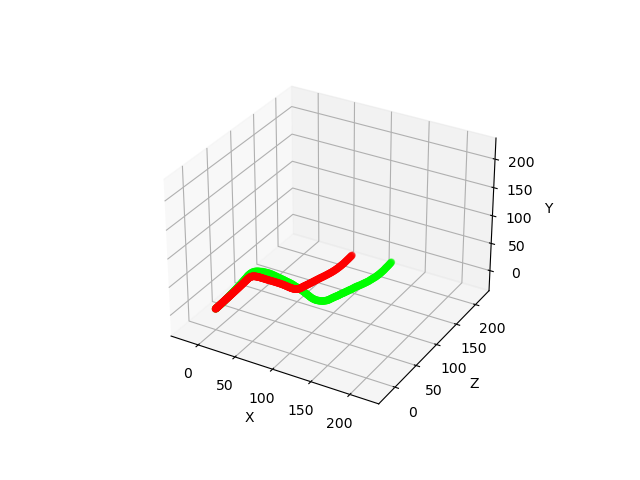

In [9]:
%matplotlib widget
plt.ion()

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(t_abs_all[:, 0], t_abs_all[:, 2], t_abs_all[:, 1], color=[(0, 1, 0)])

maximum = None
minimum = None

if KITTI == True:
    t_abs_gt = np.array(t_abs_gt)
    ax.scatter(t_abs_gt[:, 0], t_abs_gt[:, 2], t_abs_gt[:, 1], color=(1, 0, 0))
    minimum = np.array(np.concatenate([t_abs_all, t_abs_gt])).min()
    maximum = np.array(np.concatenate([t_abs_all, t_abs_gt])).max()
else:
    minimum = np.array(t_abs_all).min()
    maximum = np.array(t_abs_all).max()

ax.set_xlim([minimum, maximum])
ax.set_ylim([minimum, maximum])
ax.set_zlim([minimum, maximum])
ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_zlabel('Y')

plt.show()
